In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tqdm
from collections import deque

from generator import *
from cmaps import *

  0%|          | 0/1000000 [00:00<?, ?it/s]


completed in 3 iterations


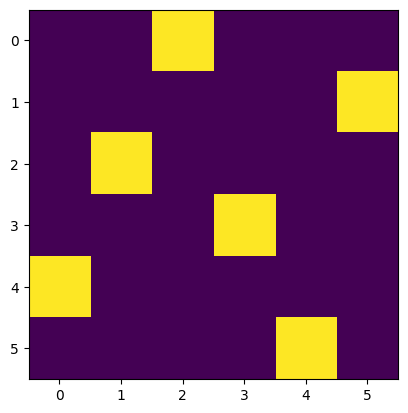

In [3]:
trees = plant_trees(6, 1, maxiter = 1000000)

plt.imshow(trees)

time = 0.005063772201538086


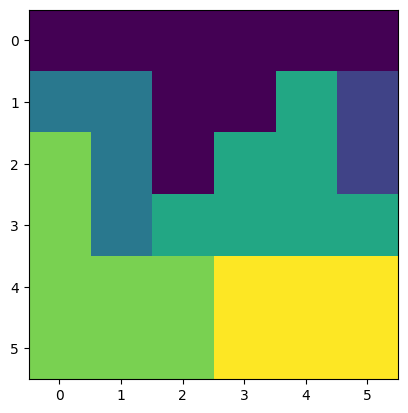

In [4]:
start = time.time()
singular_forest = generate_singular_forest(trees)
print(f"time = {time.time() - start}")
plt.imshow(singular_forest)

time = 0.5745551586151123


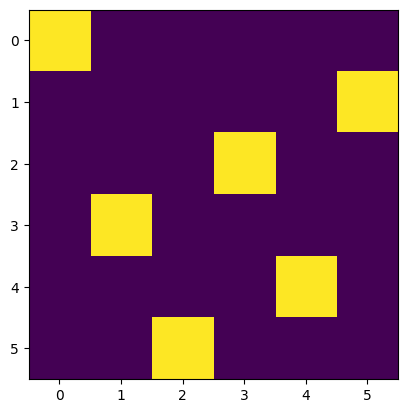

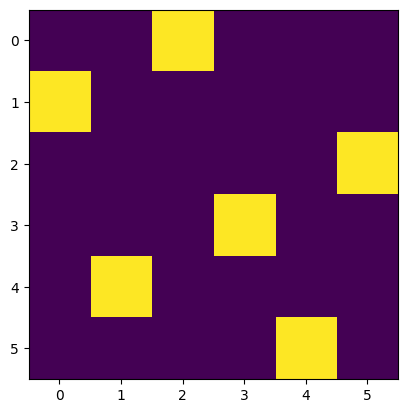

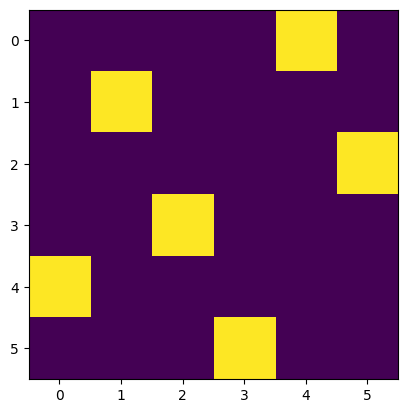

In [5]:
start = time.time()
solutions, visited = place_tree(singular_forest)
print(f"time = {time.time() - start}")
for solution in solutions:
    plt.imshow(solution)
    plt.show()

  0%|          | 0/1000000 [00:00<?, ?it/s]

completed in 11 iterations


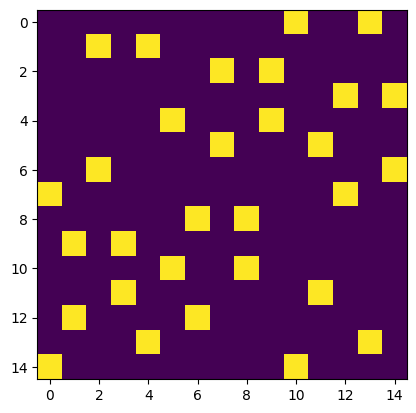

In [6]:
trees = plant_trees(15, 2, maxiter = 1000000)

plt.imshow(trees)

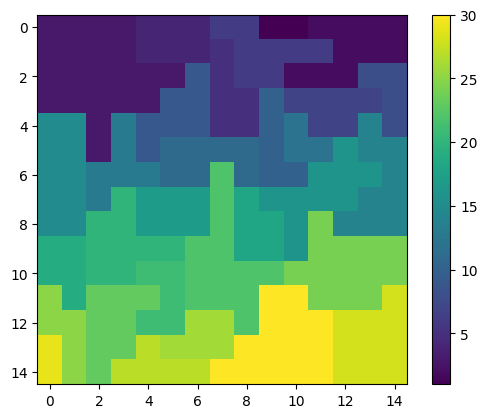

In [7]:
singular_forest = generate_singular_forest(trees)
plt.imshow(singular_forest)
plt.colorbar()

In [8]:
adjacency_list = calc_adjacency_list(singular_forest)
adj_matrix = adj_list_to_matrix(adjacency_list)

 68%|██████▊   | 136000/200000 [00:03<00:01, 37897.26it/s]

merge pattern found after 136048 iterations, temp = 0.9674907981407819


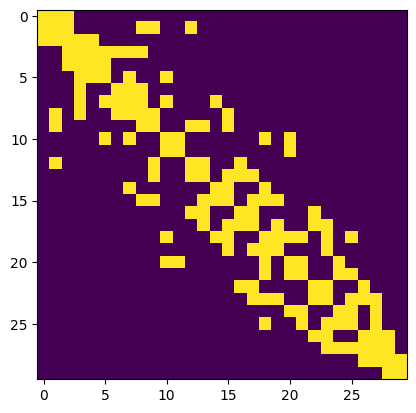

In [9]:
merged = merge_forest(singular_forest, adjacency_list, temp=0.25, maxiter=200000)

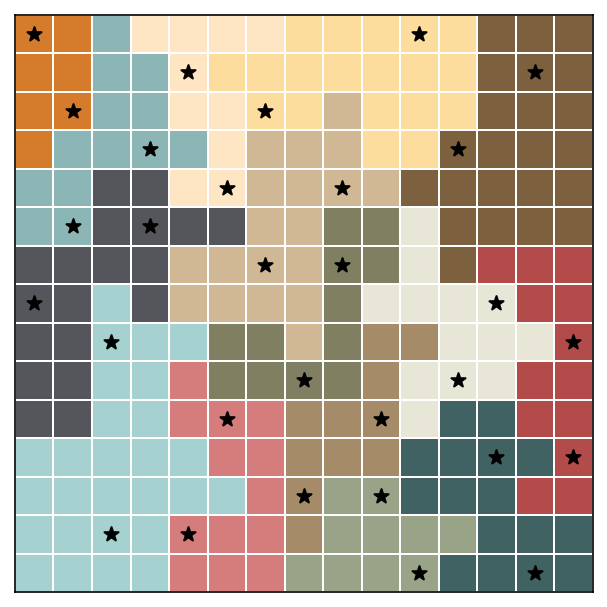

In [15]:
plot_forest(merged, trees, solution=True, cmap=desert_cmap())

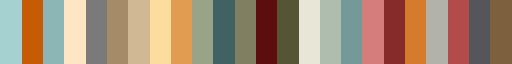

In [16]:
desert_cmap()

In [26]:
import jax.numpy as jnp
from jax import jit
from functools import partial

In [82]:
# @jit
def get_conflicting(array, i, j):
    adj_indices = []
    if i > 0 and j > 0:
        adj_indices.append([i-1, j-1])
    if i < array.shape[0] - 1 and j < array.shape[1] - 1:
        adj_indices.append([i+1, j+1])
    if j > 0 and i < array.shape[0] - 1:
        adj_indices.append([i+1, j-1])
    if j < array.shape[1] - 1 and i > 0:
        adj_indices.append([i-1, j+1])
        
    conflicting = np.ones_like(array)
    for adj_index in adj_indices:
        conflicting[adj_index[0], adj_index[1]] = 0
    conflicting[i,:] = 0
    conflicting[:,j] = 0
    return conflicting

# @jit
# def conv2d(a, f):
#     a = np.array(jnp.pad(a, ((1,1),(1,1)), mode='constant', constant_values=(0,0)))
#     s = f.shape + tuple(np.subtract(a.shape, f.shape) + 1)
#     strd = np.lib.stride_tricks.as_strided
#     subM = strd(a, shape = s, strides = a.strides * 2)
#     return jnp.einsum('ij,ijkl->kl', f, subM)

@jit
def adjacents(array, kernel):
    return jax.scipy.signal.convolve2d(array, kernel, mode='same', boundary='fill', fillvalue=0, precision=None)

# @jit
# def find_adjacents(array):
#     kernel = jnp.ones((3, 3), dtype=int)
#     return jnp.where((adjacents(array, kernel) - array) * array > 0, 1, 0)

@jit
def find_available(array, n=1):
    kernel = jnp.ones((3, 3), dtype=int)
    d = array.shape[0]
    cols = jnp.broadcast_to(jnp.where(jnp.sum(array, axis=1) > n-1, 1, 0), (d,d))
    rows = jnp.broadcast_to(jnp.where(jnp.sum(array, axis=0) > n-1, 1, 0), (d,d))
    adjs = adjacents(array, kernel)
    opens = jnp.where(cols + rows + adjs > 0, 0, 1)
    return opens

# @partial(jit, static_argnums=1)
# def find_collisions(array, n=1):
#     collisions = array.copy()
#     collides = jnp.broadcast_to(jnp.where(jnp.sum(array, axis=0) > n, 1, 0), (array.shape[1], array.shape[0])) + jnp.broadcast_to(jnp.where(jnp.sum(array, axis=1) > n, 1, 0), array.shape).T + find_adjacents(array)
#     collisions = jnp.where(collisions * collides > 0, 1, 0)
#     return collisions


def plant_trees(d, n, maxiter = 1000000):
    trees = jnp.zeros((d,d), dtype=int)
    count = 0
    with tqdm.tqdm(total=maxiter) as pbar:
        while jnp.sum(trees) < n*d and count < maxiter:
            avail = find_available(trees, n=n)
            if jnp.any(avail):
                avail_list = jnp.argwhere(avail)
                i = np.random.randint(0, avail_list.shape[0])
                trees = trees.at[avail_list[i][0], avail_list[i][1]].set(1)
                continue
            else:
                opens = np.where(trees == 0, 1, 0)
                opens_list = jnp.argwhere(opens)
                i = np.random.randint(0, opens_list.shape[0])
                
                trees = trees * get_conflicting(trees, opens_list[i][0], opens_list[i][1])
                trees = trees.at[opens_list[i][0], opens_list[i][1]].set(1)
            count += 1
            if count % 1000 == 0:
                pbar.update(1000)
            
    pbar.close()
    if count < maxiter:
        print(f'completed in {count} iterations')
        return trees
    else:
        print(f'exited early after {count} iterations')
        return 0

In [83]:
plant_trees(10, 2, maxiter = 1000000)

  1%|          | 8000/1000000 [00:32<1:06:22, 249.06it/s]


KeyboardInterrupt: 

In [84]:
jit(plant_trees(10, 2, maxiter = 1000000))

  0%|          | 2000/1000000 [00:08<1:10:54, 234.56it/s]


KeyboardInterrupt: 

In [16]:
%timeit -n 10 plant_trees(10, 2, maxiter = 1000000)

  0%|          | 0/1000000 [00:07<?, ?it/s]


completed in 621 iterations


  0%|          | 0/1000000 [00:02<?, ?it/s]


completed in 166 iterations


  0%|          | 0/1000000 [00:01<?, ?it/s]


completed in 94 iterations


  0%|          | 1000/1000000 [00:14<4:06:41, 67.49it/s]


completed in 1299 iterations


  0%|          | 0/1000000 [00:04<?, ?it/s]


completed in 353 iterations


  0%|          | 0/1000000 [00:01<?, ?it/s]


completed in 131 iterations


  0%|          | 0/1000000 [00:01<?, ?it/s]


completed in 139 iterations


  0%|          | 0/1000000 [00:07<?, ?it/s]


completed in 666 iterations


  0%|          | 0/1000000 [00:00<?, ?it/s]


completed in 12 iterations


  0%|          | 0/1000000 [00:00<?, ?it/s]


completed in 34 iterations


  0%|          | 0/1000000 [00:02<?, ?it/s]


completed in 231 iterations


  0%|          | 0/1000000 [00:01<?, ?it/s]


completed in 90 iterations


  0%|          | 1000/1000000 [00:12<3:27:41, 80.17it/s]


completed in 1124 iterations


  0%|          | 0/1000000 [00:01<?, ?it/s]


completed in 121 iterations


  0%|          | 0/1000000 [00:00<?, ?it/s]


completed in 64 iterations


  0%|          | 0/1000000 [00:00<?, ?it/s]


completed in 36 iterations


  0%|          | 0/1000000 [00:00<?, ?it/s]


completed in 7 iterations


  0%|          | 0/1000000 [00:00<?, ?it/s]


completed in 63 iterations


  0%|          | 1000/1000000 [00:13<3:53:04, 71.44it/s]


completed in 1308 iterations


  0%|          | 0/1000000 [00:04<?, ?it/s]


completed in 395 iterations


  0%|          | 0/1000000 [00:00<?, ?it/s]


completed in 6 iterations


  0%|          | 0/1000000 [00:05<?, ?it/s]


completed in 522 iterations


  0%|          | 0/1000000 [00:03<?, ?it/s]


completed in 283 iterations


  0%|          | 0/1000000 [00:04<?, ?it/s]


completed in 367 iterations


  0%|          | 0/1000000 [00:01<?, ?it/s]


completed in 95 iterations


  0%|          | 0/1000000 [00:06<?, ?it/s]


completed in 589 iterations


  0%|          | 0/1000000 [00:01<?, ?it/s]


completed in 161 iterations


  0%|          | 0/1000000 [00:00<?, ?it/s]


completed in 42 iterations


  0%|          | 0/1000000 [00:01<?, ?it/s]


completed in 117 iterations


  0%|          | 0/1000000 [00:00<?, ?it/s]


completed in 33 iterations


  0%|          | 0/1000000 [00:07<?, ?it/s]


completed in 703 iterations


  0%|          | 0/1000000 [00:04<?, ?it/s]


completed in 442 iterations


  0%|          | 0/1000000 [00:06<?, ?it/s]


completed in 557 iterations


  0%|          | 0/1000000 [00:01<?, ?it/s]


completed in 168 iterations


  0%|          | 0/1000000 [00:05<?, ?it/s]


completed in 534 iterations


  0%|          | 0/1000000 [00:00<?, ?it/s]


completed in 43 iterations


  0%|          | 0/1000000 [00:05<?, ?it/s]


completed in 553 iterations


  0%|          | 0/1000000 [00:00<?, ?it/s]


completed in 46 iterations


  0%|          | 0/1000000 [00:06<?, ?it/s]


completed in 603 iterations


  0%|          | 0/1000000 [00:01<?, ?it/s]


completed in 141 iterations


  0%|          | 0/1000000 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [52]:
test = jnp.zeros((3,3), dtype=int)
test = test.at[1,1].set(1)
n=1

In [53]:
jnp.broadcast_to(jnp.where(jnp.sum(test, axis=1) > n-1, 1, 0), (d,d))

Array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=int32, weak_type=True)

In [57]:
import jax

In [66]:
jax.scipy.signal.convolve2d(test, test, mode='same', boundary='fill', fillvalue=0, precision=None)

Array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]], dtype=float32)